In [1]:
import os
import tempfile
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread # Install scikit-image if needed
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense,Dropout,MaxPooling2D,Flatten
from keras import Model, layers

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('/kaggle/input/ima205-challenge-2020/data/train.csv')
test = pd.read_csv('/kaggle/input/ima205-challenge-2020/data/test.csv')

In [3]:
def append_ext(fn):
    return fn+".jpg"

train_jpg = train.copy()
train_jpg['name'] = train_jpg['name'].apply(append_ext)
train_jpg['person'] = train_jpg['person'].astype('str')

test_jpg = test.copy()
test_jpg['name'] = test_jpg['name'].apply(append_ext)
test_jpg['person'] = test_jpg['person'].astype('str')

In [4]:
input_path = '/kaggle/input/ima205-challenge-2020/data/im/'

In [5]:
from sklearn.model_selection import train_test_split

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_jpg['name'], 
                                                  train_jpg['person'], 
                                                  test_size=val_split, 
                                                  stratify=train_jpg['person'],
                                                 random_state=42)

X_df = pd.DataFrame(np.concatenate((X_train, X_val)),columns=['name'])
y_df = pd.DataFrame(np.concatenate((y_train, y_val)),columns=['person'])

train_jpg = pd.concat([X_df,y_df],axis=1)

In [6]:
train_datagen = ImageDataGenerator(
#     shear_range=10,
#     zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=val_split)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_jpg,
    directory = input_path,
    x_col="name",
    y_col="person",
    subset="training",
    batch_size=128,
    class_mode='categorical',
    target_size=(224,224))

valid_generator = train_datagen.flow_from_dataframe(
    dataframe = train_jpg,
    directory = input_path,
    x_col="name",
    y_col="person",
    subset="validation",
    batch_size=128,
    class_mode='categorical',
    target_size=(224,224))

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_jpg,
    directory = input_path,
    x_col="name",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(224,224))

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames.


In [7]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

## Visualization functions

In [8]:
def plot_history(history_):
    plt.title('loss')
    plt.plot(history_.history['loss'], label='train')
    plt.plot(history_.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    plt.title('Accuracy')
    plt.plot(history_.history['accuracy'], label='train')
    plt.plot(history_.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    
    plt.title('Mean f1 score')
    plt.plot(history_.history['f1'], label='train')
    plt.plot(history_.history['val_f1'], label='test')
    plt.legend()
    plt.show()
    
    plt.title('Precision')
    plt.plot(history_.history['precision'], label='train')
    plt.plot(history_.history['val_precision'], label='test')
    plt.legend()
    plt.show()
    
    plt.title('Recall')
    plt.plot(history_.history['recall'], label='train')
    plt.plot(history_.history['val_recall'], label='test')
    plt.legend()
    plt.show()


In [9]:
def print_confusion_matrix(model):
    y_pred = model.predict_generator(valid_generator,verbose=1)
    y_pred = np.argmax(y_pred,axis=1)

    print('Confusion Matrix')
    print(confusion_matrix(valid_generator.classes, y_pred))
    print('Classification Report')
    print(classification_report(valid_generator.classes, y_pred))

In [10]:
def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [11]:
def add_regularization(model, regularizer=keras.regularizers.l2(0.0005)):

    if not isinstance(regularizer, keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

## Model 1 : No frozen layer, VGG16 FC 

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=True)

# for k in range(18):
#     vgg16.layers[k].trainable = False

#vgg16 = add_regularization(vgg16)

fc1 = vgg16.layers[-3]
fc2 = vgg16.layers[-2]

dropout1 = Dropout(0.5)
dropout2 = Dropout(0.5)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
x = Dense(2, activation='softmax')(x)


#Then create the corresponding model 
model1 = Model(input=vgg16.input, output=x)
model1.summary()

553467904/553467096 [==============================] - 34s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [13]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',f1,precision,recall])



history1 = model1.fit_generator(generator=train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,  
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,)

Epoch 1/100
31/31 [==============================] - 43s 1s/step - loss: 0.8168 - accuracy: 0.6878 - f1: 0.5983 - precision: 0.6870 - recall: 0.6870 - val_loss: 0.4007 - val_accuracy: 0.7969 - val_f1: 0.7277 - val_precision: 0.7969 - val_recall: 0.7969
Epoch 2/100
31/31 [==============================] - 33s 1s/step - loss: 0.4680 - accuracy: 0.8045 - f1: 0.7480 - precision: 0.8039 - recall: 0.8039 - val_loss: 0.3344 - val_accuracy: 0.8349 - val_f1: 0.7812 - val_precision: 0.8339 - val_recall: 0.8339
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 0.3956 - accuracy: 0.8445 - f1: 0.7983 - precision: 0.8438 - recall: 0.8438 - val_loss: 0.3287 - val_accuracy: 0.8406 - val_f1: 0.7908 - val_precision: 0.8402 - val_recall: 0.8402
Epoch 4/100
31/31 [==============================] - 31s 1s/step - loss: 0.3447 - accuracy: 0.8642 - f1: 0.8229 - precision: 0.8652 - recall: 0.8652 - val_loss: 0.2744 - val_accuracy: 0.8463 - val_f1: 0.8058 - val_precision: 0.8463 - val_rec

In [14]:
model1.save('/kaggle/working/model1.h5')

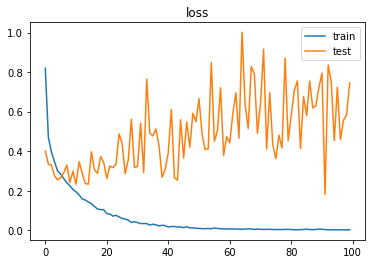

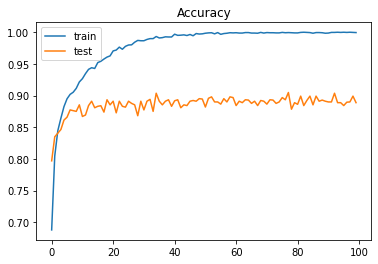

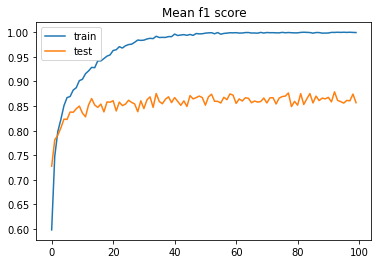

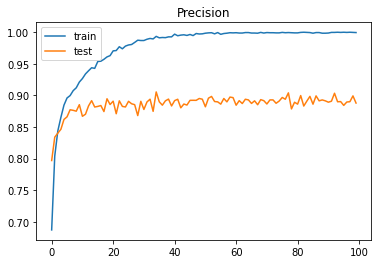

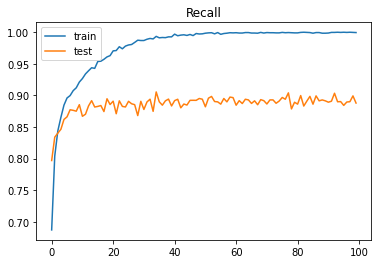

In [15]:
plot_history(history1)

In [16]:
print_confusion_matrix(model1)

8/8 [==============================] - 5s 644ms/step
Confusion Matrix
[[525 176]
 [220  79]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       701
           1       0.31      0.26      0.29       299

    accuracy                           0.60      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.59      0.60      0.59      1000



In [17]:
test_generator.reset()
pred = model1.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
df_submission = test.copy()
df_submission['person'] = predicted_class_indices
df_submission.to_csv('/kaggle/working/pred_model1.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file
print('Done')

157/157 [==============================] - 35s 221ms/step
Done


## Model 2 : 3 first layers frozen, VGG16 FC  

In [18]:
vgg16 = VGG16(weights='imagenet', include_top=True)

for k in range(5):
    vgg16.layers[k].trainable = False

vgg16 = add_regularization(vgg16)

fc1 = vgg16.layers[-3]
fc2 = vgg16.layers[-2]

dropout1 = Dropout(0.5)
dropout2 = Dropout(0.5)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
x = Dense(2, activation='softmax')(x)


#Then create the corresponding model 
model2 = Model(input=vgg16.input, output=x)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [19]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',f1,precision,recall])



history2 = model2.fit_generator(generator=train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,  
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,)

Epoch 1/100
31/31 [==============================] - 30s 954ms/step - loss: 1.9753 - accuracy: 0.6973 - f1: 0.6177 - precision: 0.6971 - recall: 0.6971 - val_loss: 1.5239 - val_accuracy: 0.8225 - val_f1: 0.7464 - val_precision: 0.8225 - val_recall: 0.8225
Epoch 2/100
31/31 [==============================] - 27s 884ms/step - loss: 1.6638 - accuracy: 0.8053 - f1: 0.7467 - precision: 0.8062 - recall: 0.8062 - val_loss: 1.6016 - val_accuracy: 0.8326 - val_f1: 0.7820 - val_precision: 0.8316 - val_recall: 0.8316
Epoch 3/100
31/31 [==============================] - 27s 878ms/step - loss: 1.5694 - accuracy: 0.8481 - f1: 0.8060 - precision: 0.8480 - recall: 0.8480 - val_loss: 1.6171 - val_accuracy: 0.8612 - val_f1: 0.8170 - val_precision: 0.8616 - val_recall: 0.8616
Epoch 4/100
31/31 [==============================] - 27s 860ms/step - loss: 1.5387 - accuracy: 0.8649 - f1: 0.8240 - precision: 0.8659 - recall: 0.8659 - val_loss: 1.5274 - val_accuracy: 0.8498 - val_f1: 0.7964 - val_precision: 0.84

In [20]:
model2.save('/kaggle/working/model2.h5')

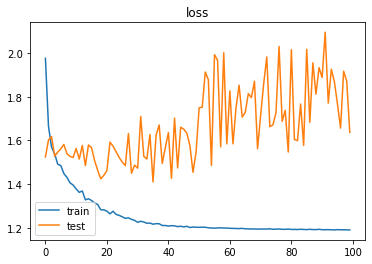

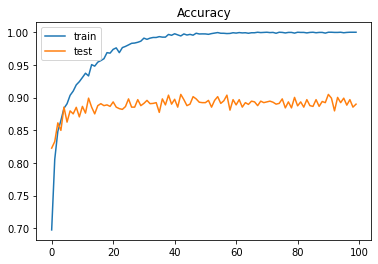

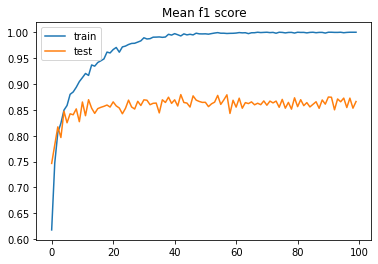

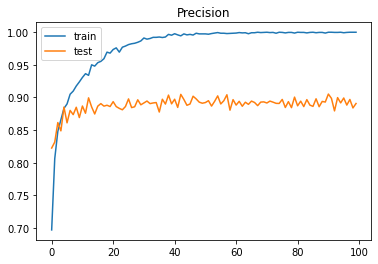

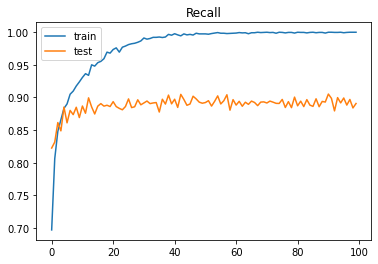

In [21]:
plot_history(history2)

In [22]:
print_confusion_matrix(model2)

8/8 [==============================] - 5s 657ms/step
Confusion Matrix
[[522 179]
 [228  71]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       701
           1       0.28      0.24      0.26       299

    accuracy                           0.59      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.57      0.59      0.58      1000



In [23]:
test_generator.reset()
pred = model2.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
df_submission = test.copy()
df_submission['person'] = predicted_class_indices
df_submission.to_csv('/kaggle/working/pred_model2.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file
print('Done')

157/157 [==============================] - 25s 157ms/step
Done


## Model 3 : All conv layers frozen, VGG16 fc

In [24]:
def add_regularization_onlyfc(model, regularizer=keras.regularizers.l2(0.0005)):

    if not isinstance(regularizer, keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of keras.regularizers.Regularizer")
        return model

    for k in range(1,3):
        layer = model.layers[-k]
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [25]:
vgg16 = VGG16(weights='imagenet', include_top=True)

vgg16 = add_regularization_onlyfc(vgg16)

for layer in vgg16.layers:
    layer.trainable = False

fc1 = vgg16.layers[-3]
fc2 = vgg16.layers[-2]

fc1.trainable = True
fc2.trainable = True

dropout1 = Dropout(0.5)
dropout2 = Dropout(0.5)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
x = Dense(2, activation='softmax')(x)


#Then create the corresponding model 
model3 = Model(input=vgg16.input, output=x)
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [26]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',f1,precision,recall])


history3 = model3.fit_generator(generator=train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,  
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,)

Epoch 1/100
31/31 [==============================] - 25s 792ms/step - loss: 1.2205 - accuracy: 0.6798 - f1: 0.5964 - precision: 0.6792 - recall: 0.6792 - val_loss: 0.5897 - val_accuracy: 0.8058 - val_f1: 0.7555 - val_precision: 0.8058 - val_recall: 0.8058
Epoch 2/100
31/31 [==============================] - 24s 785ms/step - loss: 0.7876 - accuracy: 0.7975 - f1: 0.7492 - precision: 0.7986 - recall: 0.7986 - val_loss: 0.6802 - val_accuracy: 0.8154 - val_f1: 0.7693 - val_precision: 0.8159 - val_recall: 0.8159
Epoch 3/100
31/31 [==============================] - 23s 757ms/step - loss: 0.6676 - accuracy: 0.8236 - f1: 0.7787 - precision: 0.8241 - recall: 0.8241 - val_loss: 0.6026 - val_accuracy: 0.8257 - val_f1: 0.7811 - val_precision: 0.8255 - val_recall: 0.8255
Epoch 4/100
31/31 [==============================] - 24s 762ms/step - loss: 0.6066 - accuracy: 0.8394 - f1: 0.8004 - precision: 0.8417 - recall: 0.8417 - val_loss: 0.5174 - val_accuracy: 0.8440 - val_f1: 0.7952 - val_precision: 0.84

In [27]:
model3.save('/kaggle/working/model3.h5')

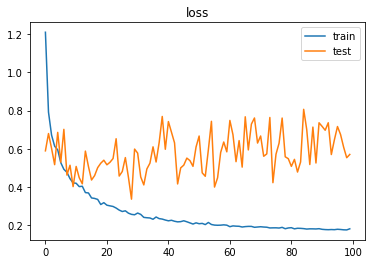

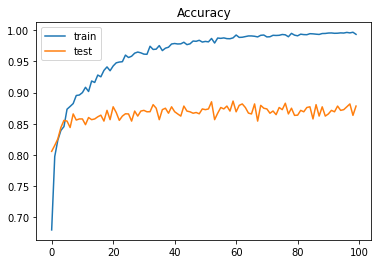

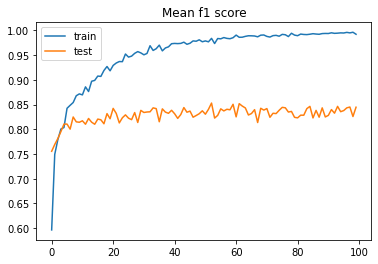

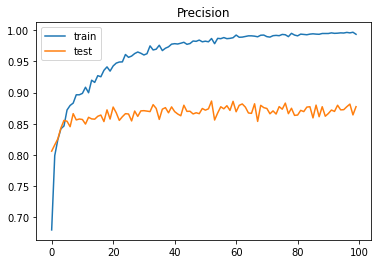

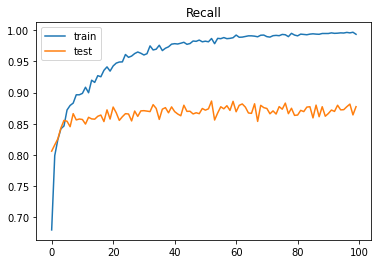

In [28]:
plot_history(history3)

In [29]:
print_confusion_matrix(model3)

8/8 [==============================] - 6s 714ms/step
Confusion Matrix
[[530 171]
 [232  67]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.76      0.72       701
           1       0.28      0.22      0.25       299

    accuracy                           0.60      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.57      0.60      0.58      1000



In [30]:
test_generator.reset()
pred = model3.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
df_submission = test.copy()
df_submission['person'] = predicted_class_indices
df_submission.to_csv('/kaggle/working/pred_model3.csv', index=None, sep=',', mode='w')
print('Done')

157/157 [==============================] - 25s 159ms/step
Done


## Model 4 : All conv layers frozen and one 128 fc from scratch

In [31]:
vgg16 = VGG16(weights='imagenet', include_top=True)

for layer in vgg16.layers:
    layer.trainable = False

regulizer = keras.regularizers.l2(0.0005)

fc1 = Dense(128,activation='relu',kernel_regularizer=regulizer)

dropout1 = Dropout(0.5)

# Reconnect the layers
x = vgg16.layers[-4].output
x = fc1(x)
x = dropout1(x)
x = Dense(2, activation='softmax')(x)


#Then create the corresponding model 
model4 = Model(input=vgg16.input, output=x)
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [32]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',f1,precision,recall])

history4 = model4.fit_generator(generator=train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,  
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,)

Epoch 1/100
31/31 [==============================] - 24s 784ms/step - loss: 3.4527 - accuracy: 0.6872 - f1: 0.6221 - precision: 0.6872 - recall: 0.6872 - val_loss: 0.8363 - val_accuracy: 0.7946 - val_f1: 0.7277 - val_precision: 0.7946 - val_recall: 0.7946
Epoch 2/100
31/31 [==============================] - 25s 821ms/step - loss: 0.9778 - accuracy: 0.7942 - f1: 0.7459 - precision: 0.7939 - recall: 0.7939 - val_loss: 0.7936 - val_accuracy: 0.8062 - val_f1: 0.7383 - val_precision: 0.8047 - val_recall: 0.8047
Epoch 3/100
31/31 [==============================] - 24s 770ms/step - loss: 0.7125 - accuracy: 0.8130 - f1: 0.7668 - precision: 0.8115 - recall: 0.8115 - val_loss: 0.6038 - val_accuracy: 0.7959 - val_f1: 0.7309 - val_precision: 0.7954 - val_recall: 0.7954
Epoch 4/100
31/31 [==============================] - 24s 784ms/step - loss: 0.5770 - accuracy: 0.8386 - f1: 0.7940 - precision: 0.8380 - recall: 0.8380 - val_loss: 0.6700 - val_accuracy: 0.8096 - val_f1: 0.7583 - val_precision: 0.81

In [33]:
model4.save('/kaggle/working/model4.h5')

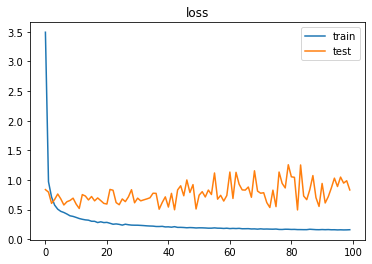

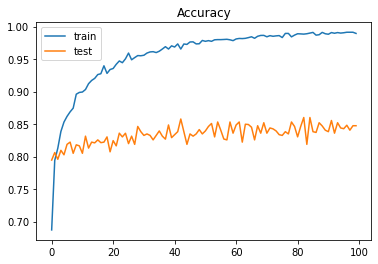

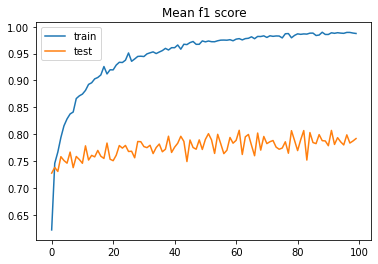

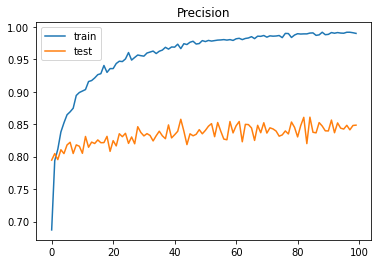

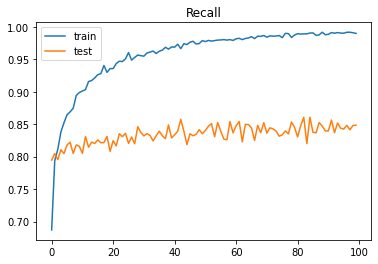

In [34]:
plot_history(history4)

In [35]:
print_confusion_matrix(model4)

8/8 [==============================] - 5s 642ms/step
Confusion Matrix
[[567 134]
 [247  52]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       701
           1       0.28      0.17      0.21       299

    accuracy                           0.62      1000
   macro avg       0.49      0.49      0.48      1000
weighted avg       0.57      0.62      0.59      1000



In [36]:
test_generator.reset()
pred = model4.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
df_submission = test.copy()
df_submission['person'] = predicted_class_indices
df_submission.to_csv('/kaggle/working/pred_model4.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file
print('Done')

157/157 [==============================] - 23s 149ms/step
Done


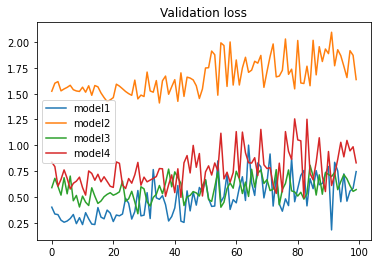

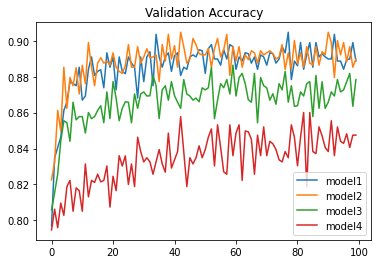

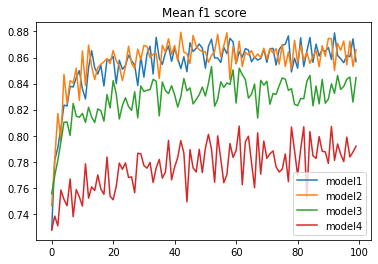

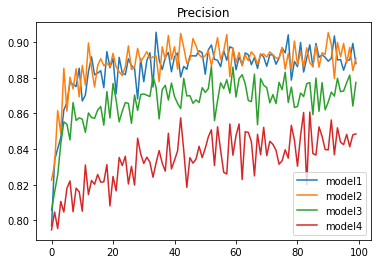

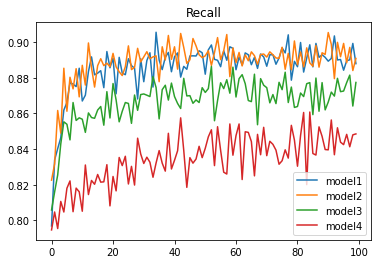

In [37]:
plt.title('Validation loss')
plt.plot(history1.history['val_loss'], label='model1')
plt.plot(history2.history['val_loss'], label='model2')
plt.plot(history3.history['val_loss'], label='model3')
plt.plot(history4.history['val_loss'], label='model4')
plt.legend()
plt.show()

plt.title('Validation Accuracy')
plt.plot(history1.history['val_accuracy'], label='model1')
plt.plot(history2.history['val_accuracy'], label='model2')
plt.plot(history3.history['val_accuracy'], label='model3')
plt.plot(history4.history['val_accuracy'], label='model4')
plt.legend()
plt.show()

plt.title('Mean f1 score')
plt.plot(history1.history['val_f1'], label='model1')
plt.plot(history2.history['val_f1'], label='model2')
plt.plot(history3.history['val_f1'], label='model3')
plt.plot(history4.history['val_f1'], label='model4')
plt.legend()
plt.show()

plt.title('Precision')
plt.plot(history1.history['val_precision'], label='model1')
plt.plot(history2.history['val_precision'], label='model2')
plt.plot(history3.history['val_precision'], label='model3')
plt.plot(history4.history['val_precision'], label='model4')
plt.legend()
plt.show()

plt.title('Recall')
plt.plot(history1.history['val_recall'], label='model1')
plt.plot(history2.history['val_recall'], label='model2')
plt.plot(history3.history['val_recall'], label='model3')
plt.plot(history4.history['val_recall'], label='model4')
plt.legend()
plt.show()